This jupyter notebook contains analysis of the counts of 'ED four-hour target breaches' and 'Delayed Transfers Of Care' at English Trusts August 2010 -> April 2016. It contains all the complete analysis steps used in the paper.

#### import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

# Load data

In [2]:
df = pd.read_csv('NHSE_data.csv')
df.shape

(80, 10)

In [3]:
df.head()

,year,month,total_attendances,total_attendances_t1,total_breaches,95%_targ,total_admissions,dtoc_a,dtoc_na,total_dtocs
0,2010-11,August,1719197.000,1138652.000,33184.00000,0.980698,425702.0000,2559,2381,4940
1,2010-11,September,1715117.000,1150728.000,41151.00000,0.976007,424900.0000,2647,2357,5004
2,2010-11,October,1753934.000,1163143.000,47414.00000,0.972967,436215.0000,2513,2075,4588
3,2010-11,November,1604591.000,1111294.571,46436.42857,0.971060,429099.0000,2352,2057,4409
4,2010-11,December,1647823.857,1159203.857,89917.28571,0.945433,452728.7143,1995,1866,3861


make flag for data used in previous analysis

In [4]:
df['flag_previous'] = 0

df.loc[0:68,'flag_previous'] = 1

remove most recent data to reproduce previous analysis.

In [5]:
df = df[df.flag_previous == 1] 

In [6]:
df = df[['total_breaches','total_dtocs']] # select only variables of interest

# Data briefing reproduction

A reproduction of the analysis in BMJ data briefing by Appleby: https://www.bmj.com/content/353/bmj.i3585

In [7]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['total_dtocs'],df['total_breaches'])

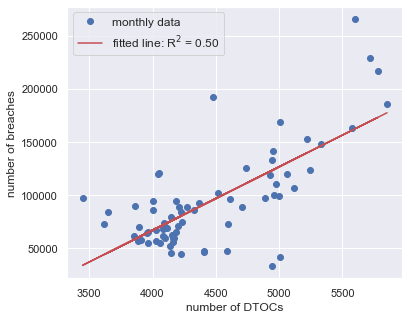

In [8]:
fig, ax = plt.subplots(figsize=(6,5))
y = df['total_breaches']
x = df['total_dtocs']
plt.plot(x,y,'o', label='monthly data')
plt.plot(df['total_dtocs'], intercept + slope*x, 'r', label='fitted line: R$^2$ = {0:.2f}'.format(r_value**2))
plt.legend(frameon=True,fontsize='large')
ax.set_xlabel('number of DTOCs')
ax.set_ylabel('number of breaches')
plt.show()

We find similar R<sup>2</sup> value that was found in the previous analysis:

In [9]:
(r_value**2).round(3)

0.504

#### distribution of data

Check distribution of each variable.

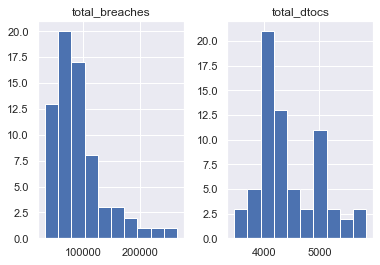

In [10]:
df.hist();

#### correlation coefficient

Data appears to not be normally distributed. Hence, we should avoid using Pearson correlation coefficient. Calculate correlation values:

In [11]:
from scipy.stats.stats import pearsonr

In [12]:
corr, p = pearsonr(df['total_dtocs'],df['total_breaches'])

In [13]:
print('Pearson')
print('Coeficient: ', corr)
print('P-value' , p)

Pearson
Coeficient:  0.710060292485
P-value 8.37892018508e-12


In [14]:
from scipy.stats.stats import spearmanr

In [15]:
corr, p = spearmanr(df['total_dtocs'],df['total_breaches'])

In [16]:
print('Spearman')
print('Coeficient: ', corr)
print('P-value' , p)

Spearman
Coeficient:  0.541634696551
P-value 1.53991353597e-06


# Investigate timeseries properties

#### Stationarity
One method to asses if timeseries is stationary is to use an augmented dickey-fuller test. This tests to see if a unit root is present within the data - which would indicate non-stationarity.

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [19]:
check_stationarity(df['total_breaches'])

ADF Statistic: -1.555714
p-value: 0.505793
	1%: -3.530
	5%: -2.905
	10%: -2.590


In [20]:
check_stationarity(df['total_dtocs'])

ADF Statistic: 1.641969
p-value: 0.997978
	1%: -3.551
	5%: -2.914
	10%: -2.595


The p-value >> 0.05 indicates that there is a unit root present in both of the timeseries. This implies each variable is non-stationary.

#### Assess level of autocorrelation using ACF

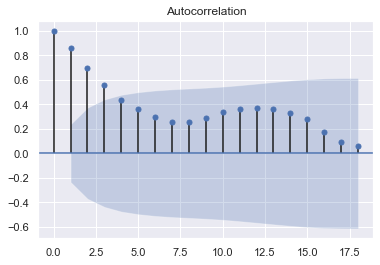

In [21]:
fig = sm.graphics.tsa.plot_acf(df['total_breaches'],lags=18)

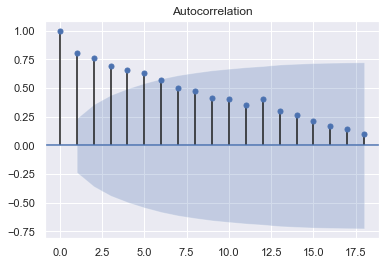

In [22]:
fig = sm.graphics.tsa.plot_acf(df['total_dtocs'],lags=18)

High autocorrelation values for many lags in both timeseries demontrate that each time point is highly dependent on the previous ones. This may indicate an increasing growth over time; one cause of a timeseries being non-stationary. This is very clear upon plotting the time-series below.

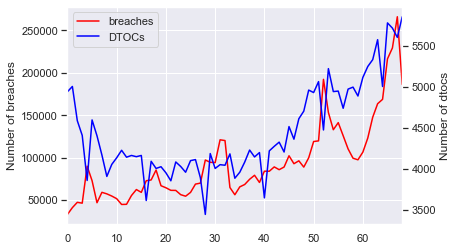

In [23]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

df.total_breaches.plot(color='red', ax=ax)#, width=width)#, position=1)
df.total_dtocs.plot(color='blue', ax=ax2)

ax.set_ylabel('Number of breaches')
ax2.set_ylabel('Number of dtocs')
ax2.grid(b=False)

#sort legend
lns = ax.get_lines()+ax2.get_lines()
ax.legend(lns,['breaches','DTOCs'],frameon=True)

plt.show()

# Detrend using fitted polynomial

One method to detrend the time-series is by fitting polynomial equations and subtracting these from the time-series.

In [24]:
def func_dtoc(x, a, b, c):
    return (a * x) + (b * x**2) + c

In [25]:
def detrend_using_func(dta,column,func,ylabel,color='b'):
    
    #### fit func
    xdata = dta.index
    ydata = dta[column]
    popt, pcov = scipy.optimize.curve_fit(func, xdata, ydata)
    
    #### plot fig
    fig = plt.figure() # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes
    dta[column].plot(color=color, ax=ax, label=ylabel)#, width=width)#, position=0)
    plt.plot(xdata, func(xdata, *popt), color+ '--',
              label='fit:a=%5.3f,  b=%5.3f, c=%5.3f' % tuple(popt)) #

    ax.set_ylabel(ylabel)
    ax.legend(frameon=True)
    plt.show()
    
    #### make new column with detrended data
    dta.loc[dta.index,column+'_detrend'] = dta[column] - func(dta[column].index,popt[0],popt[1],popt[2])
    
    return dta

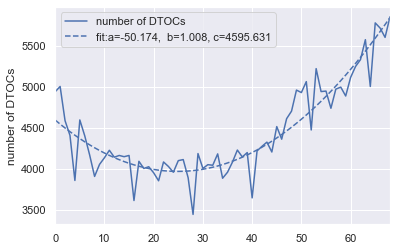

In [26]:
df = detrend_using_func(df,'total_dtocs',func_dtoc,'number of DTOCs')

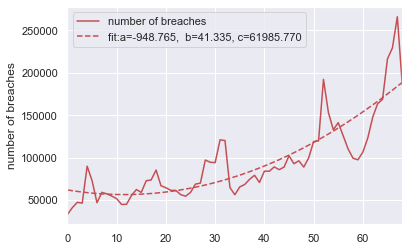

In [27]:
df = detrend_using_func(df,'total_breaches',func_dtoc,'number of breaches','r')

Plotting the detrended time-series (below) we see there is now no increasing trend over time.

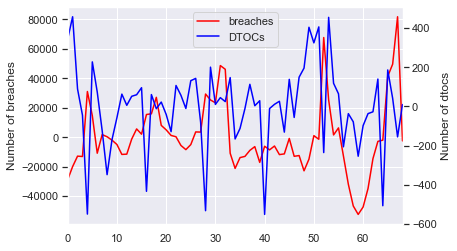

In [28]:
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

df.total_breaches_detrend.plot(color='red', ax=ax)#, width=width)#, position=1)
df.total_dtocs_detrend.plot(color='blue', ax=ax2)

ax.set_ylabel('Number of breaches')
ax2.set_ylabel('Number of dtocs')
ax2.grid(b=False)

#sort legend
lns = ax.get_lines()+ax2.get_lines()
ax2.legend(lns,['breaches','DTOCs'],frameon=True)

plt.show()

#### Is the data now stationary?
Again using a dickey-fuller test to ascertain if detrended data is stationarity.

In [29]:
check_stationarity(df['total_breaches_detrend'])

ADF Statistic: -3.952409
p-value: 0.001681
	1%: -3.530
	5%: -2.905
	10%: -2.590


In [30]:
check_stationarity(df['total_dtocs_detrend'])

ADF Statistic: -1.586171
p-value: 0.490537
	1%: -3.551
	5%: -2.914
	10%: -2.595


Although we have removed the long-term trend, and breaches now appears to be stationary, it appears that the DTOCs timeseries may still not be stationary (p-value = 0.490).

Re-assesing the level of autocorrelation using the ACF we see that the seasonal variation is still present in the timeseries, but the high and persistent levels of autocorrelation over many lags has been removed.

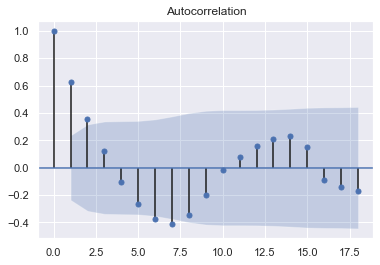

In [31]:
fig = sm.graphics.tsa.plot_acf(df['total_breaches_detrend'],lags=18)

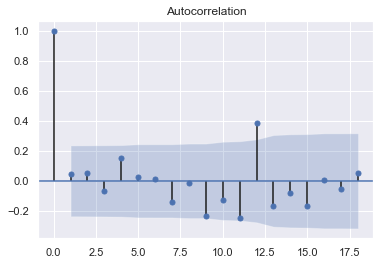

In [32]:
fig = sm.graphics.tsa.plot_acf(df['total_dtocs_detrend'],lags=18)

# Analysis on detrended data

Completing the same linear regression analysis on the detrended data as before we find there are much smaller correlation coeficients.

In [33]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['total_dtocs_detrend'],df['total_breaches_detrend'])

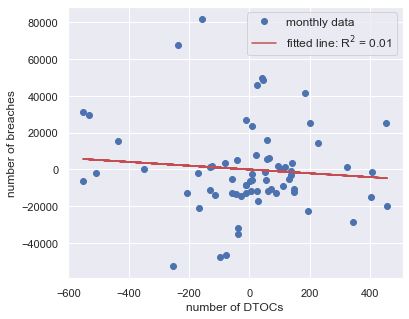

In [34]:
fig, ax = plt.subplots(figsize=(6,5))
y = df['total_breaches_detrend']
x = df['total_dtocs_detrend']
plt.plot(x,y,'o', label='monthly data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line: R$^2$ = {0:.2f}'.format(r_value**2))
plt.legend(frameon=True,fontsize='large')
ax.set_xlabel('number of DTOCs')
ax.set_ylabel('number of breaches')
plt.show()

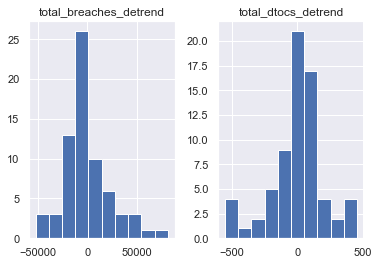

In [35]:
df[['total_breaches_detrend','total_dtocs_detrend']].hist();

In [36]:
xdata=df['total_breaches']
ydata=df['total_dtocs']

from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr

def test_corrs(xdata,ydata,test):
    result = test(xdata,ydata)
    return(result)

def create_test_df(df):
    index =[]
    corrs = []
    ps = []
    
    corr,p = test_corrs(df['total_breaches'],df['total_dtocs'],pearsonr)
    index.append('original (pearson)')
    corrs.append(corr)
    ps.append(p)
    
    
    corr,p = test_corrs(df['total_breaches'],df['total_dtocs'],spearmanr)
    index.append('original (spearman)')
    corrs.append(corr)
    ps.append(p)
    
    corr,p = test_corrs(df['total_breaches_detrend'],df['total_dtocs_detrend'],pearsonr)
    index.append('detrended (pearson)')
    corrs.append(corr)
    ps.append(p)
    
    
    
    corr,p = test_corrs(df['total_breaches_detrend'],df['total_dtocs_detrend'],spearmanr)
    index.append('detrended (spearman)')
    corrs.append(corr)
    ps.append(p)
    
    
    result = pd.DataFrame(data={'correlations':corrs,'p_values':ps},index=index)
    return(result)
    
corrs = create_test_df(df)

In [37]:
corrs.round(4) # produce table for paper

,correlations,p_values
original (pearson),0.7101,0.0000
original (spearman),0.5416,0.0000
detrended (pearson),-0.0915,0.4544
detrended (spearman),0.0178,0.8844


The p-value roughly indicates the probability of an uncorrelated system
 producing datasets that have a correlation at least as extreme
 as the one computed from these datasets. The high p-values for the detrended data indicate that there is a high probability that breaches and DTOCs have little correlation to one another.

# Plots for paper with time highlighted in colour

R^2 value of data with original analysis:  0.5


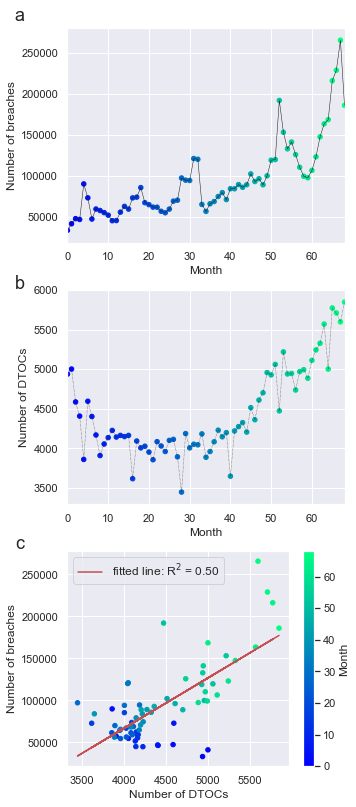

In [38]:
#### setup figure plots
fig,ax = plt.subplots(3,1,figsize=(5,11));
VarA = 'Number of DTOCs'
VarB = 'Number of breaches'

df['Month'] = df.index;
df[VarA] = df['total_dtocs'];
df[VarB] = df['total_breaches'];


#### plot line graph
df[[VarB]].plot(ax=ax[0],color='k', linewidth=0.5);
df[[VarA]].plot(color='k', linewidth=0.5, linestyle=':',ax=ax[1]);

cmap='winter'

#### scatter on line plots
df[['Month',VarB]].plot('Month',VarB,kind='scatter',ax=ax[0],c='Month',colormap=cmap,colorbar=False);
df[['Month',VarA]].plot('Month',VarA,kind='scatter',ax=ax[1],c='Month',colormap=cmap,colorbar=False);
ax[0].get_legend().remove()
ax[1].get_legend().remove()


#### scatter plot
df[[VarA,VarB,'Month']].plot(VarA,VarB,kind='scatter',ax=ax[2],c='Month',colormap=cmap); #,label='Monthly data');
## regression
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['total_dtocs'],df['total_breaches'])

print('R^2 value of data with original analysis: ', (r_value**2).round(2))

y = df['total_breaches']
x = df['total_dtocs']
plt.plot(x, intercept + slope*x, 'r', label='fitted line: R$^2$ = {0:.2f}'.format(r_value**2))
plt.legend(frameon=True,fontsize='large');

fig.tight_layout(pad=1)

plt.text(2700, 303000*3, 'a', fontsize=18)

plt.text(2700, 295000*2, 'b', fontsize=18)

plt.text(2700, 280000, 'c', fontsize=18);

# fig.savefig('Figure2',dpi=800)

In [39]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['total_dtocs_detrend'],df['total_breaches_detrend'])

print('R^2 value of data with detrended analysis: ', (r_value**2).round(2))

R^2 value of data with detrended analysis:  0.01


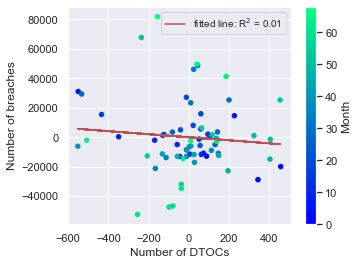

In [40]:
fig, ax = plt.subplots(figsize=(5,4))
y = df['total_breaches_detrend']
x = df['total_dtocs_detrend']
df[['total_dtocs_detrend','total_breaches_detrend','Month']].plot('total_dtocs_detrend','total_breaches_detrend',kind='scatter',ax=ax,c='Month',colormap=cmap); #,label='Monthly data');

plt.plot(x, intercept + slope*x, 'r', label='fitted line: R$^2$ = {0:.2f}'.format(r_value**2))
plt.legend(frameon=True,fontsize='medium')
ax.set_xlabel('Number of DTOCs')
ax.set_ylabel('Number of breaches')
plt.show()


fig.tight_layout(pad=1)
# fig.savefig('Figure3',dpi=800)